# Training Permutation-Invariant Networks


This week, we'll focus on permutation invariant neural networks. In general the answer here is graph neural networks but for this exercise we will focus on datasets that are just bags of objects, without any edges, i.e.
`DeepSets` as discussed in the lecture.


First, let's create a data-generating function `make_data(N)` that produces the `N` instances following data 

* each instance has 10 objects
* each object has 1 feature that either has value $x=0$ or a nonzero value $x!=0$
* for data from class 0, a random subset of 3 objects has value 1/3
* for data from class 1, a random subset of 5 objects has value 1/5

The function `make_data(N)` should return a PyTorch feature matrix of shape `(N,10,1)` and a PyTorch label array of shape `(N,1)`

* Visualize the a batch of data through `plt.imshow(X)`

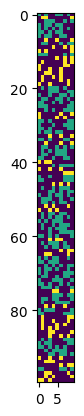

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def make_data(N):
    total = 10
    X = np.zeros((N,total))
    idx = np.random.choice(np.arange(N),size = (N//2,))
    labels = []
    for i in range(N):
        if i in idx:
            active = 3
            slots = np.random.choice(np.arange(total), size = (active,), replace = False)
            X[i][slots] = 1/active
            labels.append(0)
        else:
            active = 5
            slots = np.random.choice(np.arange(total), size = (active,), replace = False)
            X[i][slots] = 1/active
            labels.append(1)
    labels = np.array(labels)
    return torch.FloatTensor(X.reshape(N,total,1)),torch.FloatTensor(labels.reshape(-1,1))
X,y = make_data(100)
plt.imshow(X)

## Creating the Models

Now we create two models that we want to compare

* a DeepSet model
* a standard MLP

For the DeepSet create a class `DeepSet` that subclasses `torch.nn.Module`. Recall the definition of a DeepSet. It has two components

* an element wise network that just transforms the per-element features into a new representation
* a global set-wide network that takes the pooled representations of the objects and performs the final classification

For the element-wise network create a small MLP that maps `\mathbb{R} \to \mathbb{R}` with two hidden layers and a `Tanh` activation and a small number of hidden units (e.g. 5) per layer

For the global network use a single hidden layer with also a small number of units and prepare the network for binary classification (i.e. use a sigmoid as the last operation)

When implementing the `forward()` of the `DeepSet` class go through the right order of operations
* calculate the per-element values for all objects
* implement the pooling (use sum pooling) 
* pass the pooled representation into the set-wide network


In [70]:
class DeepSet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.element_wise = torch.nn.Sequential(
            torch.nn.Linear(1,5),
            torch.nn.Tanh(),
            torch.nn.Linear(5,5),
            torch.nn.Tanh(),
            torch.nn.Linear(5,1),
        )
        self.global_net = torch.nn.Sequential(
            torch.nn.Linear(1,5),
            torch.nn.Tanh(),
            torch.nn.Linear(5,1),
            torch.nn.Sigmoid()
        )
    def forward(self, X):
        inp = X.reshape(-1,1)
        H = self.element_wise(inp)
        H = H.reshape(-1,10,1)
        pooled = H.sum(axis=1)
        out = self.global_net(pooled)
        return out

For the MLP, just use a standard network architecture with `torch.nn.Sequential`

In [75]:
MLP = lambda Nhidden = 5: torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(10,Nhidden),
            torch.nn.ReLU(),
            torch.nn.Linear(Nhidden,Nhidden),
            torch.nn.ReLU(),
            torch.nn.Linear(Nhidden,1),
            torch.nn.Sigmoid()
        )

## Writing the Training Loop

Write a training loop that takes an untrained model and trains it for some number of steps (e.g. 4000)
using the Adam optimizer. At each loop iteration, draw random data from `make_data` (this is effectively an infinitely large training dataset)


* Train on binary cross entropy as a loss function.
* As you are training, track the loss value
* The `train(model)` function should return both the trained model as well as the loss history

In [79]:
def train(model):
    opt = torch.optim.Adam(model.parameters(),1e-3)
    trajectory = []
    for i in range(4000):
        X,y = make_data(100)
        p = model(X)
        loss = torch.nn.functional.binary_cross_entropy(p,y)
        trajectory.append(float(loss))
        loss.backward()
        opt.step()
        opt.zero_grad()
        if i % 500 == 0:
            print(float(loss))
    return model,np.array(trajectory)

Train both the Deep Set as well as the MLP!

In [80]:
trained_deepset,losscurve_deepset = train(DeepSet())
trained_mlp,losscurve_mlp = train(MLP())

0.6979182362556458
0.6820977926254272
0.1740533858537674
0.012241157703101635
0.005355640780180693
0.0031124691013246775
0.002017370890825987
0.001410092692822218
0.6696314215660095
0.6597276926040649
0.6356285214424133
0.5262448787689209
0.40914708375930786
0.49724847078323364
0.301835298538208
0.29015788435935974


# Comparing MLP and DeepSet

* Write a function `count_params(model)` that returns the number of parameters for the neural network
* Compute the number of parameters for both trained models
* Plot the loss curve for both the MLP as well as the DeepSet 

In [82]:
def count_params(model):
    return sum([p.numel() for p in model.parameters()])

n_deepset = count_params(trained_deepset)
n_mlp = count_params(trained_mlp)

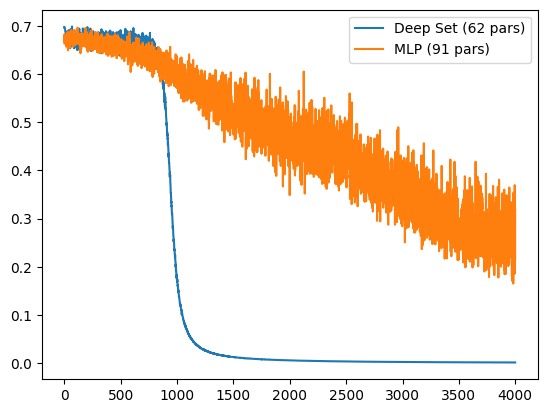

In [83]:
plt.plot(losscurve_deepset, label = f'Deep Set ({n_deepset} pars)')
plt.plot(losscurve_mlp, label = f'MLP ({n_mlp} pars)')
plt.legend()

## Verify the Permutation Invariance

The advantage of encoding known symmetries into the network is not only that the learning is faster but of course also that the symmetries hold exactly. 

* Take an example instance of the data and produce 3 random permutations of it via `np.random.permutation`
* Evaluate the model on each of these permuted inputs
* Compare / Pring the model outputs and verify that the deep set is indeed permutation invariant, while the MLP is not

In [60]:
perm0 = np.random.permutation(10)
perm1 = np.random.permutation(10)
perm2 = np.random.permutation(10)


testX1 = torch.FloatTensor(X[0][perm0]).reshape(1,10,1)
testX2 = torch.FloatTensor(X[0][perm1]).reshape(1,10,1)
testX3 = torch.FloatTensor(X[0][perm2]).reshape(1,10,1)

print('DeepSet')
for XX in [testX1,testX2,testX3]:
    print(trained_deepset(XX))

print('MLP')
for XX in [testX1,testX2,testX3]:
    print(trained_mlp(XX))

DeepSet
tensor([[0.9993]], grad_fn=<SigmoidBackward0>)
tensor([[0.9993]], grad_fn=<SigmoidBackward0>)
tensor([[0.9993]], grad_fn=<SigmoidBackward0>)
MLP
tensor([[0.7028]], grad_fn=<SigmoidBackward0>)
tensor([[0.5811]], grad_fn=<SigmoidBackward0>)
tensor([[0.9780]], grad_fn=<SigmoidBackward0>)


# Extra Question

* How many parameters do you need in order to match the Deep Set performance with the MLP?
* In the Deep Set try removing the non-Linearity in the element wise network
* can you explain what is happening and why?